**Machine Learning and Spatial data**

**Predicting Spatial Data**

Ladino Álvarez Ricardo Arturo

22-01-2020

Parts of the notebook

* Data Base
* Pixel
* Meshgrid
* Machine Learning
   - RandomForestRegressor
   - ExtraTreesRegressor
   - GradientBoostingRegressor
   - KNeighborsRegressor
* Mapeo de predicciones

In [1]:
### Librerias Base

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
%matplotlib inline


### Librerias complemento
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

In [2]:
base_data = pd.read_csv('Ricardo.csv', index_col=0)
base_data['geometry'] = [geometry.Point(x, y) for x, y in zip(base_data['longitud'], base_data['latitud'])]
base_data = gpd.GeoDataFrame(base_data, geometry='geometry', crs="EPSG:4326")
base_data.head()

,longitud,latitud,x,y,alt,total,geometry
cve_estac,,,,,,,
AJU,-99.162611,19.154286,482901.0,2117906.0,2942,17.61,POINT (-99.16261 19.15429)
AJM,-99.207744,19.272161,478170.0,2130954.0,2548,18.42,POINT (-99.20774 19.27216)
BJU,-99.159596,19.370464,483240.0,2141827.0,2249,18.10,POINT (-99.15960 19.37046)
CAM,-99.169794,19.468404,482179.0,2152665.0,2233,19.10,POINT (-99.16979 19.46840)
CCA,-99.176111,19.326111,481500.0,2136920.0,2294,17.53,POINT (-99.17611 19.32611)


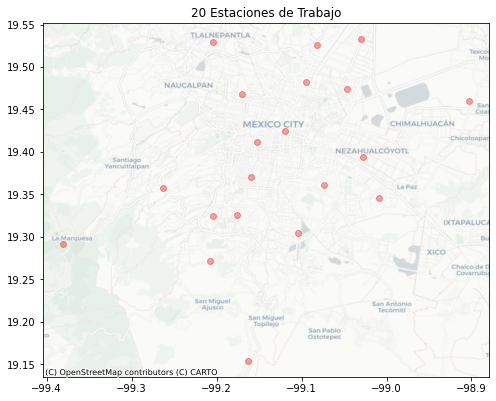

In [3]:
#data.plot(total)
ax = base_data.plot(alpha=0.35, color="xkcd:red", figsize=(8, 8))
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=base_data.crs.to_string())
ax.set_title(f"{base_data.shape[0]} Estaciones de Trabajo");

In [4]:
base_data.head()

,longitud,latitud,x,y,alt,total,geometry
cve_estac,,,,,,,
AJU,-99.162611,19.154286,482901.0,2117906.0,2942,17.61,POINT (-99.16261 19.15429)
AJM,-99.207744,19.272161,478170.0,2130954.0,2548,18.42,POINT (-99.20774 19.27216)
BJU,-99.159596,19.370464,483240.0,2141827.0,2249,18.10,POINT (-99.15960 19.37046)
CAM,-99.169794,19.468404,482179.0,2152665.0,2233,19.10,POINT (-99.16979 19.46840)
CCA,-99.176111,19.326111,481500.0,2136920.0,2294,17.53,POINT (-99.17611 19.32611)


In [5]:
base_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 20 entries, AJU to XAL
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   longitud  20 non-null     float64 
 1   latitud   20 non-null     float64 
 2   x         20 non-null     float64 
 3   y         20 non-null     float64 
 4   alt       20 non-null     int64   
 5   total     20 non-null     float64 
 6   geometry  20 non-null     geometry
dtypes: float64(5), geometry(1), int64(1)
memory usage: 1.2+ KB


In [6]:
### Minimo y maximo del valor de predicciones
vmin = base_data.total.min()
vmax = base_data.total.max()

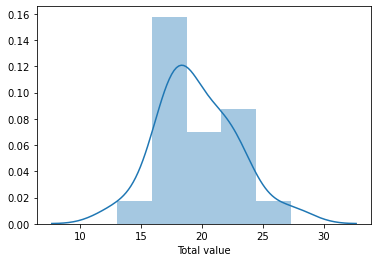

In [7]:
ax = sns.distplot(base_data.total.dropna(), axlabel='Total value')
#ax.get_figure()

In [8]:
### Variable de uso predictivo.

resmag = base_data['total']

In [9]:
### Se define el tamaño del pixel - grid

pixel_size = 250

x_range = np.arange(base_data.x.min() - base_data.x.min() % pixel_size,
                    base_data.x.max(), pixel_size)
y_range = np.arange(base_data.y.min() - base_data.y.min() % pixel_size,
                    base_data.y.max(), pixel_size)[::-1]

In [10]:
### Forma de meshgrid

shape = (len(y_range), len(x_range))

print('Forma', shape)

Forma (169, 201)


In [11]:
### Definicion de mesgrid extendido

extent = xmin, xmax, ymin, ymax = x_range.min(), x_range.max(), y_range.min(), y_range.max()

In [12]:
### Información general

print(f" Rows: {shape[0]}",f" Columns: {shape[1]} \n" )
print(f" xmin: {xmin}",f" xmax: {xmax} \n" )
print(f" ymin: {ymin}",f" ymax: {ymax} \n" )


 Rows: 169  Columns: 201 

 xmin: 460000.0  xmax: 510000.0 

 ymin: 2117750.0  ymax: 2159750.0 



In [13]:
## Creacion de mesgrig final

x_mesh, y_mesh = np.meshgrid(x_range, y_range)

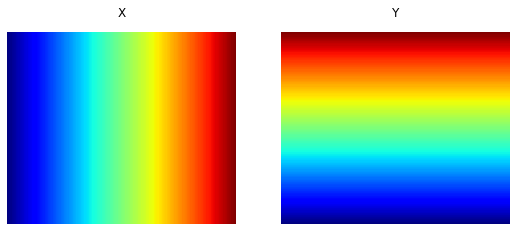

In [14]:
## Se plotea las regiones de los valores

fig, axes = plt.subplots(1, 2, figsize=(9, 9))
for ax, data, title in zip(axes.ravel(), [x_mesh, y_mesh], ['X', 'Y']):
    ax.matshow(data, extent=extent, cmap='jet'); ax.set_axis_off(); ax.set_title(title)

In [15]:
### Se convierten las coordenadas de cada muestra en valores de índice de la matriz

base_data.loc[:, 'X_INDEX'] = ((base_data.x - xmin) / pixel_size).astype(int)
base_data.loc[:, 'Y_INDEX'] = (shape[0] - ((base_data.y - ymin) / pixel_size)).astype(int)

In [16]:
### Cree una matriz vacía con la shapeque definimos anteriormente y agregue los 
## valores de prediccion en las posiciones definidas por el índice.

base_array = np.zeros(shape)
base_array[:] = np.nan
base_array[base_data.Y_INDEX, base_data.X_INDEX] = resmag


### Machine Learning

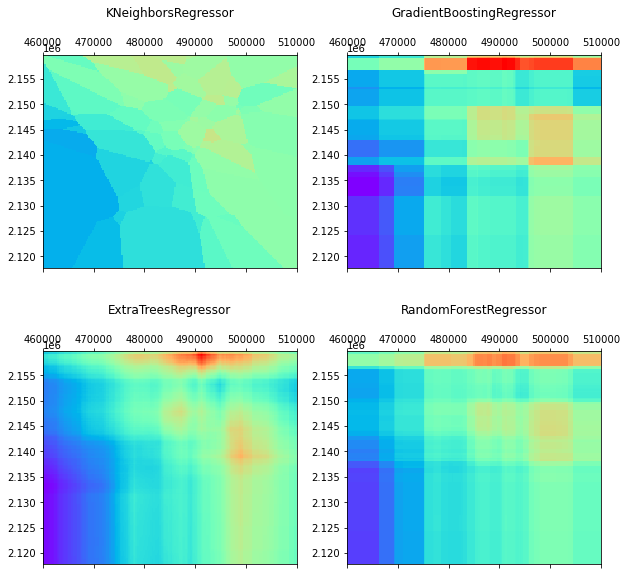

In [18]:
#### Algoritomos de Machine y ensamble 

regrs = [KNeighborsRegressor(),
        GradientBoostingRegressor(),
        ExtraTreesRegressor(),
        RandomForestRegressor()
       ]

y_fit = base_array[np.isfinite(base_array)]
x_index_fit, y_index_fit = np.where(np.isfinite(base_array))
x_index_pred, y_index_pred = np.where(base_array)

X_fit = MinMaxScaler().fit_transform(np.vstack([x_index_fit, y_index_fit]).T)
X_pred = MinMaxScaler().fit_transform(np.vstack([x_index_pred, y_index_pred]).T)

fig, axes = plt.subplots(2, 2, figsize=(10,10))
for ax, regr, title in zip(axes.ravel(),
                          regrs,
                          ['KNeighborsRegressor', 
                           'GradientBoostingRegressor', 
                           'ExtraTreesRegressor', 
                           'RandomForestRegressor']):

    regr.fit(X=X_fit, y=y_fit)
    y_pred = regr.predict(X=X_pred)
    ax.matshow(y_pred.reshape(shape), extent=extent, cmap='rainbow', vmin=vmin, vmax=vmax)
    ax.set_title(title, y=1.15)

In [19]:
### Polynomial Features

n_angles = 60

X_var, Y_var, angle = np.meshgrid(x_range, y_range, n_angles)

angles = np.deg2rad(np.linspace(0, 180, n_angles, endpoint=False))

X = X_var + np.tan(angles) * Y_var


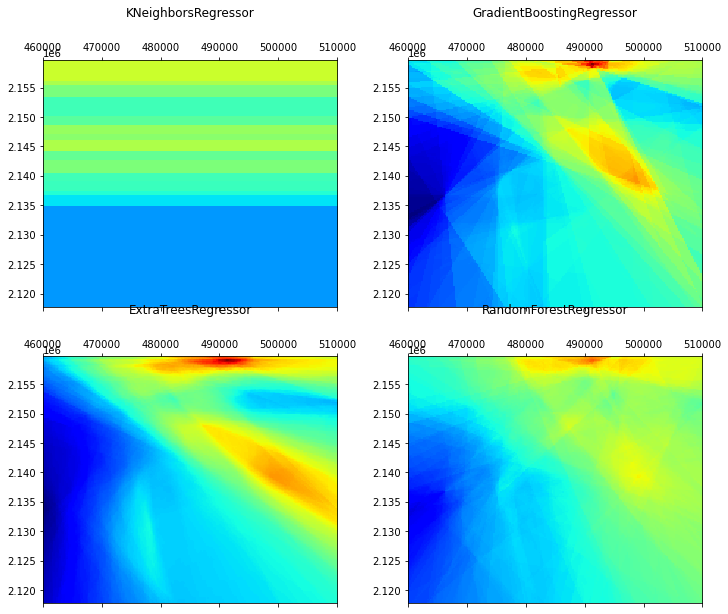

In [20]:
X_fit = X[x_index_fit, y_index_fit]

X_pred = X.reshape(-1, 60)
preds = dict()
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, regr, title in zip(axes.ravel(),
                          regrs,
                            ['KNeighborsRegressor',
                             'GradientBoostingRegressor', 
                             'ExtraTreesRegressor', 
                             'RandomForestRegressor']):

    regr.fit(X=X_fit, y=y_fit)
    y_pred = regr.predict(X=X_pred)
    preds[title] = y_pred
    ax.matshow(y_pred.reshape(shape), extent=extent, cmap='jet', vmin=vmin, vmax=vmax)
    ax.set_title(title, y=1.15)

In [21]:
Data_RF = preds['RandomForestRegressor'].reshape(shape)
Data_ETF = preds['ExtraTreesRegressor'].reshape(shape)
Data_GBB = preds['GradientBoostingRegressor'].reshape(shape)

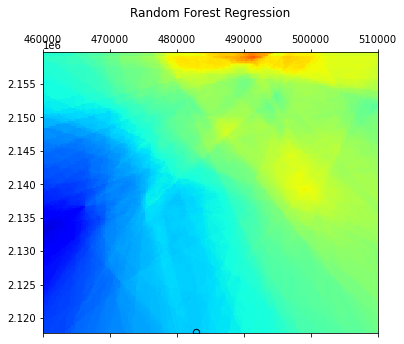

In [23]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.matshow(Data_RF, extent=extent, cmap='jet', vmin=vmin, vmax=vmax)
ax.scatter(base_data.x[::25], base_data.y[::25], 
           cmap='jet', s=40, c=resmag[::25], vmin=vmin, vmax=vmax, linewidths=1, edgecolors='k')
ax.set_title("Random Forest Regression\n");

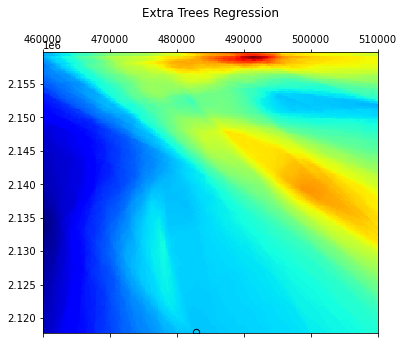

In [24]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.matshow(Data_ETF, extent=extent, cmap='jet', vmin=vmin, vmax=vmax)
ax.scatter(base_data.x[::25], base_data.y[::25], 
           cmap='jet', s=40, c=resmag[::25], vmin=vmin, vmax=vmax, linewidths=1, edgecolors='k')
ax.set_title("Extra Trees Regression\n");